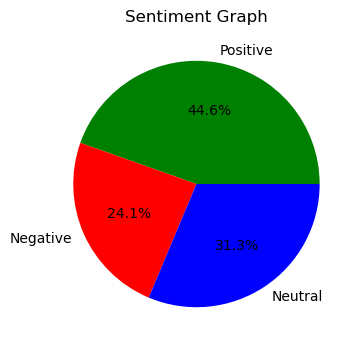

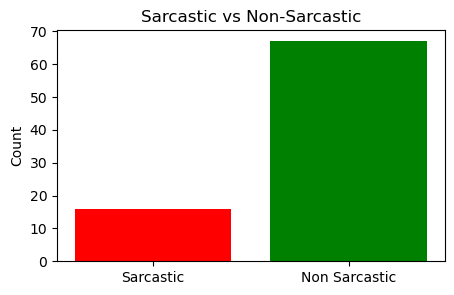

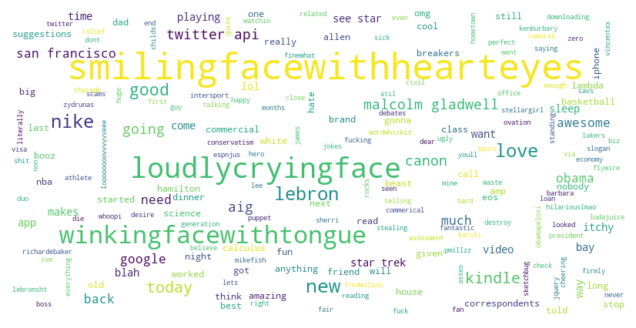

In [13]:
from tkinter import messagebox
from tkinter import *
import tkinter
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from string import punctuation
from nltk.corpus import stopwords
import pandas as pd
from emoji import demojize
import re
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

main = tkinter.Tk()
main.title("Sarcasmet: Extension of Lexicon Algorithm for Emoji-Based Sarcasm Detection from Twitter Data")
main.geometry("1300x1200")

sid = SentimentIntensityAnalyzer()

global filename
global dataset
global process
global sarcastic
global sentiment

def checkSarcasm(sentence):
    pos = []
    neg = []
    neu = []
    arr = sentence.split(' ')
    for i in range(len(arr)):
        word = arr[i].strip()
        if word == 'smilingfacewithhearteyes':
            word = 'excellent'
        if word == 'loudlycryingface':
            word = 'bad'
        if word == 'winkingfacewithtongue':
            word = 'happy'    
        if (sid.polarity_scores(word)['compound']) >= 0.1:
            pos.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.1:
            neg.append(word)
        else:
            neu.append(word)
    return pos,neg,neu    

def clean_doc(doc):
    tokens = doc.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

def upload():
    clear_plots()
    global filename
    global dataset
    dataset = []
    
    filename = filedialog.askopenfilename(initialdir="dataset", filetypes=[("CSV files", "*.csv")])
    if not filename:
        messagebox.showwarning("Warning", "No file selected!")
        return
    
    text.delete('1.0', END)
    text.insert(END, filename + " loaded\n")

    try:
        train = pd.read_csv(filename, encoding='utf8', sep='\t')  # Adjust separator if needed
        if train.shape[1] < 2:
            messagebox.showwarning("Warning", "The file does not have the expected number of columns!")
            return
        
        for i in range(len(train)):
            tweet = train.iloc[i, 0]
            tweet = tweet.lower() if pd.notna(tweet) else ''
            icon = demojize(train.iloc[i, 1].strip()) if pd.notna(train.iloc[i, 1]) else ''
            icon = re.sub('[^A-Za-z\s]+', '', icon).lower()
            msg = ' '.join([word for word in tweet.split() if len(word) > 2])
            textdata = f"{msg} {icon}".strip()
            dataset.append(textdata)

        text.insert(END, 'Total tweets found in dataset: ' + str(len(dataset)))
    
    except pd.errors.EmptyDataError:
        messagebox.showwarning("Warning", "The file is empty or couldn't be read properly!")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred while reading the file: {e}")

def Preprocessing():
    clear_plots()
    text.delete('1.0', END)
    global process
    process = []
    text.insert(END,'Messages after preprocessing and removing stopwords\n')
    text.insert(END,'====================================================================================\n')

    for i in range(len(dataset)):
        sentence = dataset[i]
        sentence = sentence.lower()
        sentence = clean_doc(sentence)
        text.insert(END, sentence + '\n')
        process.append(sentence)
                
def firstAlgorithm():
    clear_plots()
    text.delete('1.0', END)
    global sarcastic
    sarcastic = []
    for i in range(len(process)):
        sentence = process[i]
        sentiment_dict = sid.polarity_scores(sentence)
        compound = sentiment_dict['compound']
        result = ''
        if compound >= 0.1:
            result = 'Positive' 
        elif compound <= -0.1:
            result = 'Negative' 
        else:
            result = 'Neutral'
        if result == 'Positive' or result == 'Neutral':
            pos, neg, neu = checkSarcasm(sentence)
            sarcastic.append("Sarcastic" if len(neg) > 0 else "Non Sarcastic")
        else:
            sarcastic.append("Non Sarcastic")
        text.insert(END, f'Tweets : {dataset[i]}\n')
        text.insert(END, f'Positive Polarity : {sentiment_dict["pos"]}\n')
        text.insert(END, f'Negative Polarity : {sentiment_dict["neg"]}\n')
        text.insert(END, f'Neutral Polarity  : {sentiment_dict["neu"]}\n')
        text.insert(END, f'Result : {sarcastic[i]}\n')
        text.insert(END, '====================================================================================\n')
            
def secondAlgorithm():
    clear_plots()
    global sentiment
    sentiment = []
    text.delete('1.0', END)
    for i in range(len(process)):
        sentence = process[i]
        sentiment_dict = sid.polarity_scores(sentence)
        compound = sentiment_dict['compound']
        result = ''
        if compound >= 0.1:
            result = 'Positive'
        elif compound <= -0.1:
            result = 'Negative'
        else:
            result = 'Neutral'
        sentiment.append(result)
        sar = ''    
        if result == 'Positive' or result == 'Neutral':
            pos, neg, neu = checkSarcasm(sentence)
            sar = "Sarcastic" if len(neg) > 0 else "Non Sarcastic"
        else:
            sar = "Non Sarcastic"
            
        text.insert(END, f'Tweets : {dataset[i]}\n')
        text.insert(END, f'Positive Polarity : {sentiment_dict["pos"]}\n')
        text.insert(END, f'Negative Polarity : {sentiment_dict["neg"]}\n')
        text.insert(END, f'Neutral Polarity  : {sentiment_dict["neu"]}\n')
        text.insert(END, f'Result : {sar}\n')
        text.insert(END, f'Sentiment Prediction : {result}\n')
        text.insert(END, '====================================================================================\n')

global canvas
canvas = None

def clear_plots():
    global canvas
    if canvas:
        canvas.get_tk_widget().destroy()
        canvas = None

def plot_sarcastic_graph():
    clear_plots()
    text.delete('1.0', END)  # Clear previous text
    sar = sum(1 for x in sarcastic if x == "Sarcastic")
    non_sar = sum(1 for x in sarcastic if x == "Non Sarcastic")

    height = [sar, non_sar]
    bars = ('Sarcastic', 'Non Sarcastic')
    y_pos = np.arange(len(bars))

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.bar(y_pos, height, color=['red', 'green'])
    ax.set_xticks(y_pos)
    ax.set_xticklabels(bars)
    ax.set_ylabel('Count')
    ax.set_title('Sarcastic vs Non-Sarcastic')

    global canvas
    canvas = FigureCanvasTkAgg(fig, master=main)
    canvas.draw()
    canvas.get_tk_widget().place(x=450, y=150)
    
    text.insert(END, 'Sarcastic vs Non-Sarcastic Graph\n')
    text.insert(END, '====================================================================================\n')

def plot_sentiment_graph():
    clear_plots()
    text.delete('1.0', END)  # Clear previous text
    pos = sentiment.count('Positive')
    neg = sentiment.count('Negative')
    neu = sentiment.count('Neutral')

    label_X = ['Positive', 'Negative', 'Neutral']
    category_X = [pos, neg, neu]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.pie(category_X, labels=label_X, autopct='%1.1f%%', colors=['green', 'red', 'blue'])
    ax.set_title('Sentiment Graph')

    global canvas
    canvas = FigureCanvasTkAgg(fig, master=main)
    canvas.draw()
    canvas.get_tk_widget().place(x=450, y=150)
    
    text.insert(END, 'Sentiment Graph\n')
    text.insert(END, '====================================================================================\n')

def real_time_analysis():
    clear_plots()
    text.delete('1.0', END)
    user_input = real_time_input.get()
    if not user_input:
        messagebox.showwarning("Warning", "Input field is empty!")
        return
    
    cleaned_text = clean_doc(user_input)
    sentiment_dict = sid.polarity_scores(cleaned_text)
    compound = sentiment_dict['compound']
    
    if compound >= 0.1:
        result = 'Positive'
    elif compound <= -0.1:
        result = 'Negative'
    else:
        result = 'Neutral'
    
    pos, neg, neu = checkSarcasm(cleaned_text)
    sarcasm = "Sarcastic" if len(neg) > 0 else "Non Sarcastic"
    
    text.insert(END, f'User Input: {user_input}\n')
    text.insert(END, f'Cleaned Text: {cleaned_text}\n')
    text.insert(END, f'Positive Polarity: {sentiment_dict["pos"]}\n')
    text.insert(END, f'Negative Polarity: {sentiment_dict["neg"]}\n')
    text.insert(END, f'Neutral Polarity: {sentiment_dict["neu"]}\n')
    text.insert(END, f'Result: {sarcasm}\n')
    text.insert(END, f'Sentiment Prediction: {result}\n')
    text.insert(END, '====================================================================================\n')

# GUI Elements for Real-Time Analysis
real_time_label = Label(main, text="Enter Text for Real-Time Analysis:")
real_time_label.place(x=50, y=400)
real_time_label.config(font=font1)

real_time_input = Entry(main, width=80)
real_time_input.place(x=50, y=430)
real_time_input.config(font=font1)

real_time_button = Button(main, text="Analyze", command=real_time_analysis)
real_time_button.place(x=50, y=470)
real_time_button.config(font=font1)

from wordcloud import WordCloud

def plot_word_cloud():
    clear_plots()
    text.delete('1.0', END)  # Clear previous text
    all_text = ' '.join(dataset)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    global canvas
    canvas = FigureCanvasTkAgg(fig, master=main)
    canvas.draw()
    canvas.get_tk_widget().place(x=400, y=150)
    
    text.insert(END, 'Word Cloud Visualization\n')
    text.insert(END, '====================================================================================\n')

# Add button for Word Cloud Visualization
wordcloud_button = Button(main, text="Word Cloud Visualization", command=plot_word_cloud)
wordcloud_button.place(x=50, y=520)
wordcloud_button.config(font=font1)


font = ('times', 16, 'bold')
title = Label(main, text='Sarcasmet: Extension of Lexicon Algorithm for Emoji-Based Sarcasm Detection from Twitter Data')
title.config(bg='grey', fg='white')  
title.config(font=font)           
title.config(height=3, width=120)       
title.place(x=0, y=5)

font1 = ('times', 12, 'bold')
text = Text(main, height=30, width=100)
scroll = Scrollbar(text)
text.configure(yscrollcommand=scroll.set)
text.place(x=400, y=100)
text.config(font=font1)

font1 = ('times', 12, 'bold')
uploadButton = Button(main, text="Upload Social Network Dataset", command=upload)
uploadButton.place(x=50, y=100)
uploadButton.config(font=font1)  

preButton = Button(main, text="Preprocess Dataset", command=Preprocessing)
preButton.place(x=50, y=150)
preButton.config(font=font1) 

firstButton = Button(main, text="Run First System Lexicon + Polarity Computation", command=firstAlgorithm)
firstButton.place(x=50, y=200)
firstButton.config(font=font1) 

secondButton = Button(main, text="Second System Lexicon + Sentiment Prediction", command=secondAlgorithm)
secondButton.place(x=50, y=250)
secondButton.config(font=font1) 

graphButton = Button(main, text="Sentiments Graph", command=plot_sentiment_graph)
graphButton.place(x=50, y=300)
graphButton.config(font=font1)

gButton = Button(main, text="Sarcastic Graph", command=plot_sarcastic_graph)
gButton.place(x=50, y=350)
gButton.config(font=font1)

main.config(bg='light blue')
main.mainloop()
